In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Python standard library imports
from datetime import date, timedelta

# External dependency imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from scipy.special import logit

# `vaxflux` imports
from vaxflux._util import _clean_text
from vaxflux.curves import Curve, LogisticCurve
from vaxflux.data import get_ncird_weekly_cumulative_vaccination_coverage
from vaxflux.model import build_model

In [2]:
ncird_df = get_ncird_weekly_cumulative_vaccination_coverage()
ncird_df.head()

geographic_level geographic_name demographic_level demographic_name  \
0            State         Arizona           Overall        18+ years   
1            State         Arizona           Overall        18+ years   
2            State         Arizona           Overall        18+ years   
3            State         Arizona           Overall        18+ years   
4            State         Arizona           Overall        18+ years   

                  indicator_label  \
0  4-level vaccination and intent   
1  4-level vaccination and intent   
2  4-level vaccination and intent   
3  4-level vaccination and intent   
4                      Up-to-date   

                        indicator_category_label      month_week  \
0  Definitely or probably will not get a vaccine  January Week 4   
1                  Definitely will get a vaccine  January Week 4   
2      Probably will get a vaccine or are unsure  January Week 4   
3                         Received a vaccination  January Week 4   
4                                            Yes  January Week 4   

   nd_weekly_estimate  ci_half_width_95pct  n_unweighted  ...  \
0                30.8               7.8784           159  ...   
1                 6.8               4.1669           159  ...   
2                22.3               7.6134           159  ...   
3                40.1               1.8745          8592  ...   
4                40.1               1.8745          8592  ...   

   influenza_season                                   legend  \
0         2023-2024  2023-2024, Arizona, Overall (18+ years)   
1         2023-2024  2023-2024, Arizona, Overall (18+ years)   
2         2023-2024  2023-2024, Arizona, Overall (18+ years)   
3         2023-2024  2023-2024, Arizona, Overall (18+ years)   
4         2023-2024  2023-2024, Arizona, Overall (18+ years)   

  indicator_category_label_sort demographic_level_sort  demographic_name_sort  \
0                             4                      1                      1   
1                             2                      1                      1   
2                             3                      1                      1   
3                             1                      1                      1   
4                          <NA>                      1                      1   

   geographic_sort  season_sort  legend_sort  95_ci_lower  95_ci_upper  
0               14            3      3140101         22.9         38.7  
1               14            3      3140101          2.6         11.0  
2               14            3      3140101         14.7         29.9  
3               14            3      3140101         38.2         41.9  
4               14            3      3140101         38.2         41.9  

[5 rows x 22 columns]

In [3]:
incidence = ncird_df.copy()
# Get the incidence data at a national level
incidence = incidence[incidence["geographic_level"] == "National"]
# Get the incidence data by age group
incidence = incidence[
    (incidence["demographic_level"] == "Age")
    & (incidence["demographic_name"].isin(["18-49 years", "50-64 years", "65+ years"]))
]
# Get only the data were someone for sure has gotten the vaccine
incidence = incidence[
    (incidence["indicator_label"] == "Up-to-date")
    & (incidence["indicator_category_label"] == "Yes")
]
# Subset seasons with correct time granularity
incidence = incidence[
    (incidence["influenza_season"].isin(["2021-2022", "2022-2023"]))
    | (
        (incidence["month_week"].str.contains("Week"))
        & (incidence["influenza_season"].isin(["2023-2024"]))
    )
]
# Subset and rename columns
incidence = incidence[
    [
        "current_season_week_ending",
        "influenza_season",
        "geographic_name",
        "demographic_name",
        "nd_weekly_estimate",
    ]
].rename(
    columns={
        "current_season_week_ending": "time",
        "influenza_season": "season",
        "geographic_name": "region",
        "demographic_name": "strata",
        "nd_weekly_estimate": "value",
    }
)
# Fix the values column, drop NRs and convert to float
incidence = incidence[
    incidence["value"].astype("string").str.match(r"^\d+(\.\d+)?$", na=False)
]
incidence["value"] = incidence["value"].astype(float)
incidence["value"] = incidence["value"] / 100.0
# Convert the time to days since August 1st
incidence["time"] = (incidence["time"] - pd.Timestamp("2023-09-01")).dt.days
# There are some duplicates so only take the first
incidence = incidence.drop_duplicates(subset=["season", "region", "strata", "time"])
# Enforce monotonicity
incidence = incidence.sort_values(by=["season", "region", "strata", "time"])
incidence["value"] = incidence.groupby(["season", "region", "strata"])["value"].cummax()
# Convert to incidence from prevalence
incidence_dfs = []
for i, row in incidence[["season", "region", "strata"]].drop_duplicates().iterrows():
    x = incidence[
        (incidence["season"] == row["season"])
        & (incidence["region"] == row["region"])
        & (incidence["strata"] == row["strata"])
    ]["time"].to_numpy()
    y = incidence[
        (incidence["season"] == row["season"])
        & (incidence["region"] == row["region"])
        & (incidence["strata"] == row["strata"])
    ]["value"].to_numpy()
    spl = CubicSpline(x, y)
    incidence_dfs.append(
        pd.DataFrame(
            data={
                "season": row["season"],
                "region": row["region"],
                "strata": row["strata"],
                "time": x,
                "value": spl(x, nu=1),
                "prevalence": y,
            }
        )
    )
incidence = pd.concat(incidence_dfs, ignore_index=True)
# Done
incidence

season    region       strata  time     value  prevalence
0    2021-2022  National  18-49 years    43  0.005993       0.170
1    2021-2022  National  18-49 years    71  0.002200       0.279
2    2021-2022  National  18-49 years   106  0.000894       0.322
3    2021-2022  National  18-49 years   134  0.000542       0.346
4    2021-2022  National  18-49 years   162 -0.000062       0.350
..         ...       ...          ...   ...       ...         ...
148  2023-2024  National    65+ years   225 -0.000251       0.730
149  2023-2024  National    65+ years   232  0.000015       0.730
150  2023-2024  National    65+ years   239  0.000618       0.731
151  2023-2024  National    65+ years   246  0.000941       0.738
152  2023-2024  National    65+ years   253 -0.001382       0.738

[153 rows x 6 columns]

<Axes: xlabel='time', ylabel='value'>

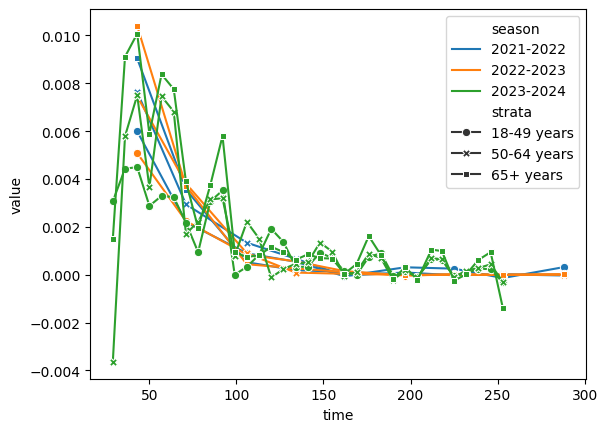

In [4]:
sns.lineplot(
    incidence,
    x="time",
    y="value",
    hue="season",
    style="strata",
    markers=True,
    dashes=False,
    errorbar=None,
)

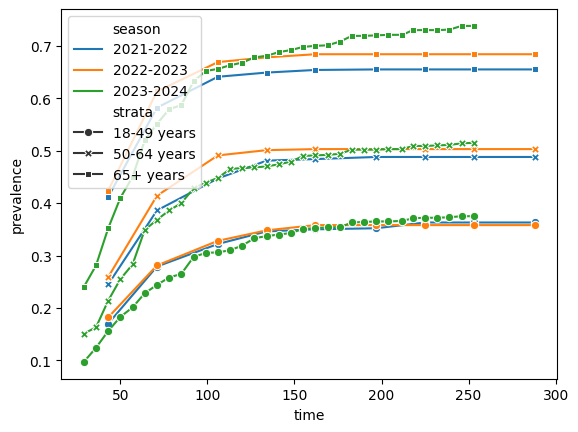

In [5]:
g = sns.lineplot(
    incidence,
    x="time",
    y="prevalence",
    hue="season",
    style="strata",
    markers=True,
    dashes=False,
    errorbar=None,
)

In [6]:
logistic_curve = LogisticCurve()

In [7]:
model_before = build_model(
    incidence[incidence["season"] != "2023-2024"][
        ["time", "season", "region", "strata", "prevalence"]
    ].rename(columns=lambda x: "value" if x == "prevalence" else x),
    "prevalence",
    "rate",
    logistic_curve,
    pm.Gamma,
    (pm.HalfNormal, {"sigma": 0.1}),
    {
        "m": (pm.Normal, {"mu": 0.0, "sigma": 0.1}),
        "r": (pm.Normal, {"mu": -4.5, "sigma": 1.0}),
        "s": (pm.Normal, {"mu": 5.300e01, "sigma": 5.0}),
        "mStrata": (
            pm.Normal,
            {
                "mu": {"18-49 years": -0.6, "50-64 years": 0.0, "65+ years": 0.6},
                "sigma": 0.1,
            },
        ),
        "rStrata": (pm.Normal, {"mu": 0.0, "sigma": 0.25}),
        "sStrata": (pm.Normal, {"mu": 0.0, "sigma": 1.0}),
    },
    season_stratified_parameters=("m", "r", "s", "mStrata"),
    season_walk_sigma=0.1,
)
model_before

          mMacro ~ Normal(0, 0.1)
mStrata1849Years ~ RandomWalk(Normal(-0.6, 0.1), Normal(0, 0.1), f())
mStrata5064Years ~ RandomWalk(Normal(0, 0.1), Normal(0, 0.1), f())
  mStrata65Years ~ RandomWalk(Normal(0.6, 0.1), Normal(0, 0.1), f())
          rMacro ~ Normal(-4.5, 1)
         rStrata ~ Normal(0, 0.25)
          sMacro ~ Normal(53, 5)
         sStrata ~ Normal(0, 1)
         epsilon ~ HalfNormal(0, 0.1)
               m ~ Deterministic(f(mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro))
               r ~ Deterministic(f(rStrata, rMacro))
               s ~ Deterministic(f(sStrata, sMacro))
          yModel ~ Deterministic(f(mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro, sStrata, rStrata, sMacro, rMacro))
       yObserved ~ Gamma(f(epsilon, mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro, sStrata, rStrata, sMacro, rMacro), f(epsilon, mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro, sStrata, rStrata, sMacro, rMacro))

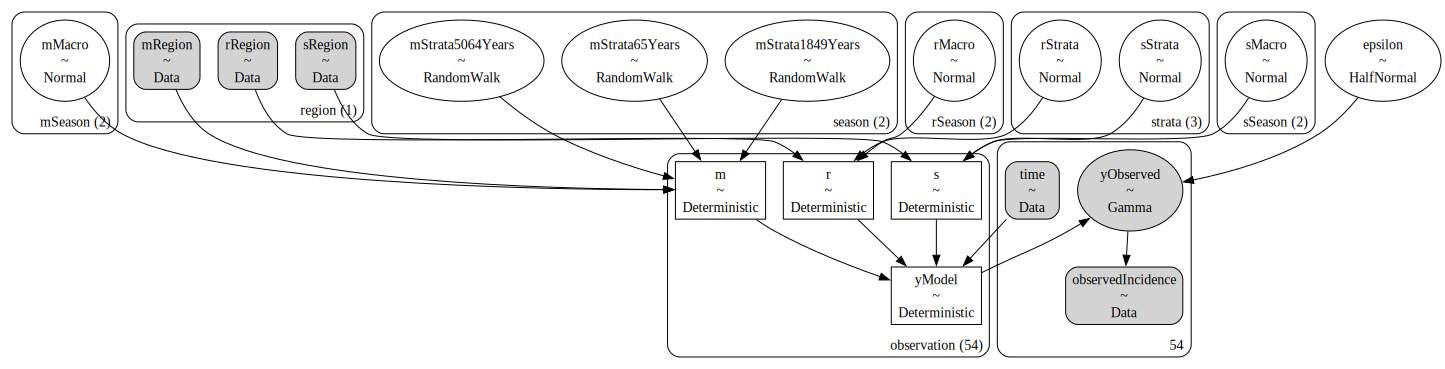

In [8]:
pm.model_to_graphviz(model_before)

In [9]:
nchains = 4
samples = 1000
with model_before:
    trace_before = pm.sample(
        draws=samples,
        tune=nchains * samples,
        chains=nchains,
        cores=nchains,
        random_seed=123,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 27 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
az.summary(trace_before)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
mMacro[2021-2022]           -0.010  0.047  -0.097    0.077      0.001   
mMacro[2022-2023]            0.043  0.062  -0.074    0.159      0.002   
mStrata1849Years[2021-2022] -0.577  0.047  -0.671   -0.495      0.001   
mStrata1849Years[2022-2023] -0.629  0.062  -0.752   -0.518      0.002   
mStrata5064Years[2021-2022] -0.048  0.047  -0.137    0.039      0.001   
...                            ...    ...     ...      ...        ...   
yModel[49]                   0.682  0.002   0.678    0.686      0.000   
yModel[50]                   0.682  0.002   0.678    0.686      0.000   
yModel[51]                   0.682  0.002   0.678    0.686      0.000   
yModel[52]                   0.682  0.002   0.678    0.686      0.000   
yModel[53]                   0.682  0.002   0.678    0.686      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
mMacro[2021-2022]              0.001    1331.0    1535.0    1.0  
mMacro[2022-2023]              0.001    1261.0    1849.0    1.0  
mStrata1849Years[2021-2022]    0.001    1324.0    1367.0    1.0  
mStrata1849Years[2022-2023]    0.001    1262.0    1776.0    1.0  
mStrata5064Years[2021-2022]    0.001    1351.0    1494.0    1.0  
...                              ...       ...       ...    ...  
yModel[49]                     0.000    3970.0    3550.0    1.0  
yModel[50]                     0.000    3974.0    3660.0    1.0  
yModel[51]                     0.000    3976.0    3660.0    1.0  
yModel[52]                     0.000    3976.0    3660.0    1.0  
yModel[53]                     0.000    3976.0    3660.0    1.0  

[235 rows x 9 columns]

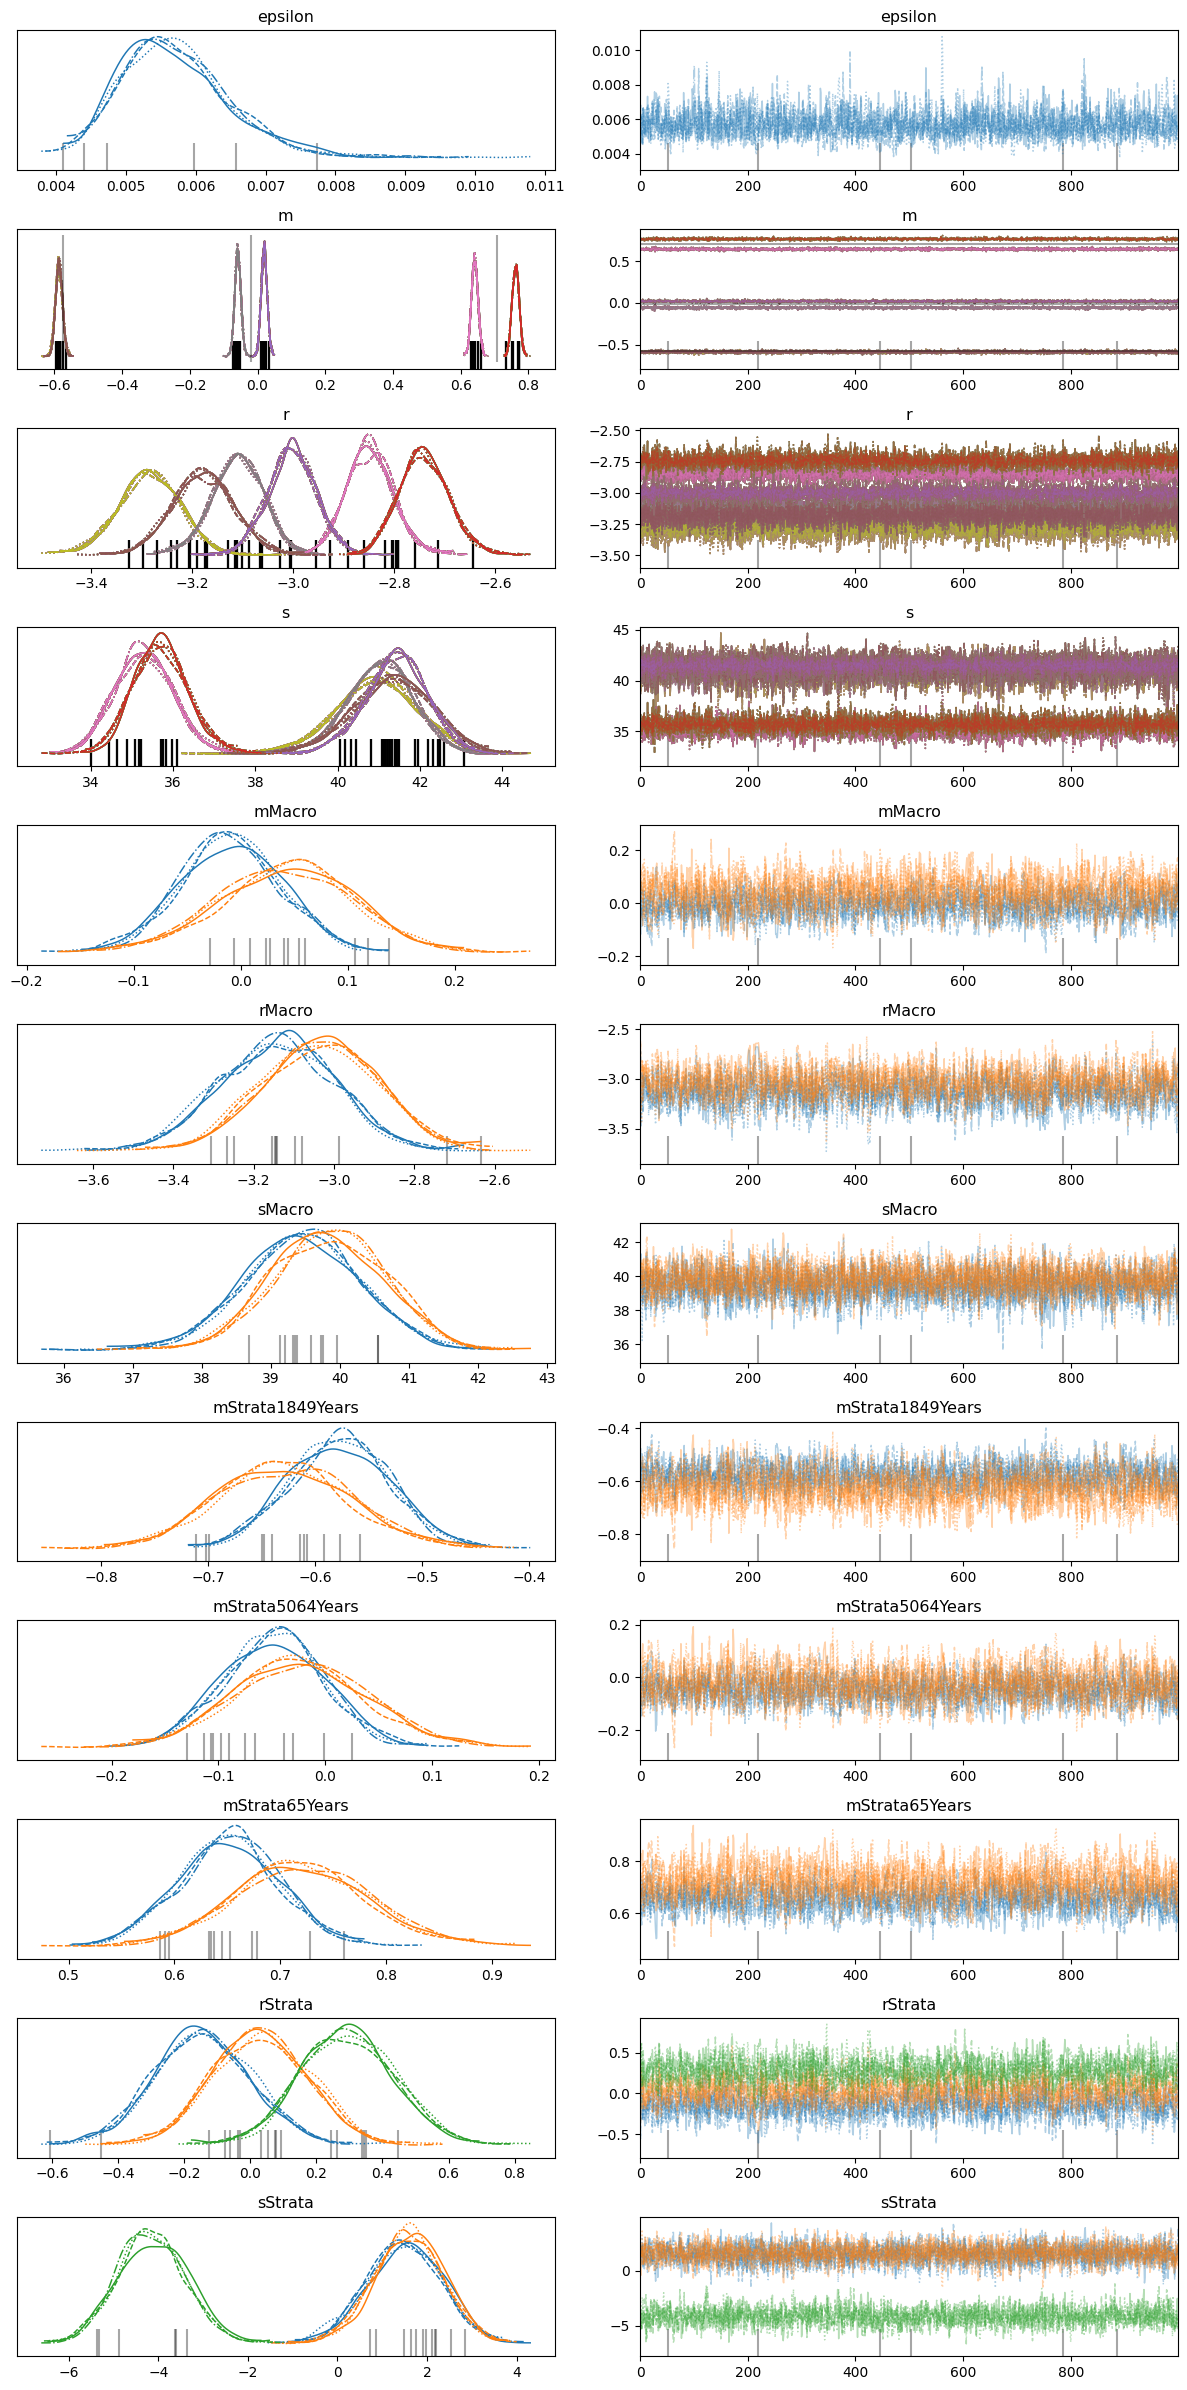

In [11]:
axes = az.plot_trace(
    trace_before,
    var_names=[
        "epsilon",
        "m",
        "r",
        "s",
        "mMacro",
        "rMacro",
        "sMacro",
        "mStrata1849Years",
        "mStrata5064Years",
        "mStrata65Years",
        "rStrata",
        "sStrata",
    ],
    kind="trace",
    lines=[
        (
            "m",
            {},
            logit(
                [0.5 * (0.363 + 0.358), 0.5 * (0.488 + 0.503), 0.5 * (0.655 + 0.684)]
            ),
        )
    ],
)
plt.tight_layout()

In [12]:
trace_before.posterior

<xarray.Dataset> Size: 8MB
Dimensions:           (chain: 4, draw: 1000, mSeason: 2, season: 2, rSeason: 2,
                       strata: 3, sSeason: 2, observation: 54)
Coordinates:
  * chain             (chain) int64 32B 0 1 2 3
  * draw              (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * mSeason           (mSeason) <U9 72B '2021-2022' '2022-2023'
  * season            (season) <U9 72B '2021-2022' '2022-2023'
  * rSeason           (rSeason) <U9 72B '2021-2022' '2022-2023'
  * strata            (strata) <U11 132B '18-49 years' '50-64 years' '65+ years'
  * sSeason           (sSeason) <U9 72B '2021-2022' '2022-2023'
  * observation       (observation) <U2 432B '0' '1' '2' '3' ... '51' '52' '53'
Data variables: (12/13)
    mMacro            (chain, draw, mSeason) float64 64kB -0.06613 ... 0.1743
    mStrata1849Years  (chain, draw, season) float64 64kB -0.5127 ... -0.7663
    mStrata5064Years  (chain, draw, season) float64 64kB 0.0134 ... -0.1627
    mStrata65Years    (chain, draw, season) float64 64kB 0.7091 ... 0.5854
    rMacro            (chain, draw, rSeason) float64 64kB -3.118 ... -2.833
    rStrata           (chain, draw, strata) float64 96kB -0.13 ... 0.07749
    ...                ...
    sStrata           (chain, draw, strata) float64 96kB 0.7128 1.621 ... -4.121
    epsilon           (chain, draw) float64 32kB 0.006298 0.006838 ... 0.00505
    m                 (chain, draw, observation) float64 2MB -0.5788 ... 0.7597
    r                 (chain, draw, observation) float64 2MB -3.248 ... -2.756
    s                 (chain, draw, observation) float64 2MB 40.62 ... 35.51
    yModel            (chain, draw, observation) float64 2MB 0.1879 ... 0.6813
Attributes:
    created_at:                 2025-04-16T14:18:43.040441+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0
    sampling_time:              26.7665011882782
    tuning_steps:               4000

In [13]:
trace_before.posterior.coords

Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * mSeason      (mSeason) <U9 72B '2021-2022' '2022-2023'
  * season       (season) <U9 72B '2021-2022' '2022-2023'
  * rSeason      (rSeason) <U9 72B '2021-2022' '2022-2023'
  * strata       (strata) <U11 132B '18-49 years' '50-64 years' '65+ years'
  * sSeason      (sSeason) <U9 72B '2021-2022' '2022-2023'
  * observation  (observation) <U2 432B '0' '1' '2' '3' ... '50' '51' '52' '53'

In [14]:
# TODO: This piece of code needs to be moved to a function and not specific to this
# particular model


def posterior_curve(  # noqa: D103
    times,
    trace: az.data.inference_data.InferenceData,
    curve: Curve,
) -> pd.DataFrame:
    chains = trace.posterior.coords["chain"].values.tolist()  # noqa: PD011
    draws = trace.posterior.coords["draw"].values.tolist()  # noqa: PD011
    seasons = trace.posterior.coords["season"].values.tolist()  # noqa: PD011
    strata = trace.posterior.coords["strata"].values.tolist()  # noqa: PD011

    times_array = np.zeros((len(times), len(chains), len(draws)))
    for i in range(len(chains)):
        for j in range(len(draws)):
            times_array[:, i, j] = times

    dfs = []
    for i, season in enumerate(seasons):
        for j, stratum in enumerate(strata):
            # shape: (chains, draws)
            m = (
                trace.posterior["mMacro"].sel(mSeason=season).values  # noqa: PD011
                + trace.posterior[f"mStrata{_clean_text(stratum)}"]  # noqa: PD011
                .sel(season=season)
                .values
            )
            # shape: (chains, draws)
            r = (
                trace.posterior["rMacro"].sel(rSeason=season).values  # noqa: PD011
                + trace.posterior["rStrata"].sel(strata=stratum).values  # noqa: PD011
            )
            # shape: (chains, draws)
            s = (
                trace.posterior["sMacro"].sel(sSeason=season).values  # noqa: PD011
                + trace.posterior["sStrata"].sel(strata=stratum).values  # noqa: PD011
            )
            # shape: (times, chains, draws)
            y = curve.evaluate(times_array, m=m, r=r, s=s).eval()
            # z = cumulative_trapezoid(y, x=times_array, initial=0.0, axis=0)
            z = curve.prevalence(times_array, m=m, r=r, s=s).eval()

            # Append to list of DataFrames
            # TODO: Inefficient, but it's the easiest way to do this for now
            for chain_idx, chain in enumerate(chains):
                for draw_idx, draw in enumerate(draws):
                    dfs.append(
                        pd.DataFrame(
                            {
                                "chain": chain,
                                "draw": draw,
                                "season": season,
                                "strata": stratum,
                                "time": times,
                                "value": y[:, chain_idx, draw_idx],
                                "prevalence": z[:, chain_idx, draw_idx],
                            }
                        )
                    )

    simulated = pd.concat(dfs)
    return simulated


simulated = posterior_curve(
    np.arange(incidence["time"].min(), incidence["time"].max() + 1),
    trace_before,
    logistic_curve,
)

In [15]:
simulated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6240000 entries, 0 to 259
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   chain       int64  
 1   draw        int64  
 2   season      object 
 3   strata      object 
 4   time        int64  
 5   value       float64
 6   prevalence  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 380.9+ MB


In [16]:
simulated_summary = (
    simulated.groupby(["season", "strata", "time"])[["value", "prevalence"]]
    .agg(
        [
            lambda x: np.quantile(x, 0.005),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, 0.995),
        ]
    )
    .reset_index()
)
simulated_summary.columns = simulated_summary.columns.to_flat_index()
simulated_summary = simulated_summary.rename(
    columns={
        k: v
        for k, v in zip(
            simulated_summary.columns,
            [
                "season",
                "strata",
                "time",
                "value_q005",
                "value_q500",
                "value_q995",
                "prevalence_q005",
                "prevalence_q500",
                "prevalence_q995",
            ],
        )
    }
)
simulated_summary

season       strata  time    value_q005    value_q500    value_q995  \
0     2021-2022  18-49 years    29  2.782188e-03  3.178667e-03  3.594904e-03   
1     2021-2022  18-49 years    30  2.797374e-03  3.203555e-03  3.633434e-03   
2     2021-2022  18-49 years    31  2.809184e-03  3.227307e-03  3.670326e-03   
3     2021-2022  18-49 years    32  2.819638e-03  3.248436e-03  3.708418e-03   
4     2021-2022  18-49 years    33  2.828729e-03  3.267958e-03  3.743492e-03   
...         ...          ...   ...           ...           ...           ...   
1555  2022-2023    65+ years   284  4.726186e-10  4.991974e-09  2.430791e-08   
1556  2022-2023    65+ years   285  4.382805e-10  4.680558e-09  2.296142e-08   
1557  2022-2023    65+ years   286  4.064373e-10  4.388306e-09  2.168952e-08   
1558  2022-2023    65+ years   287  3.769076e-10  4.114301e-09  2.048808e-08   
1559  2022-2023    65+ years   288  3.495234e-10  3.857634e-09  1.935318e-08   

      prevalence_q005  prevalence_q500  prevalence_q995  
0            0.126744         0.139254         0.153157  
1            0.130241         0.142436         0.155954  
2            0.133778         0.145658         0.158774  
3            0.137330         0.148913         0.161627  
4            0.140964         0.152193         0.164517  
...               ...              ...              ...  
1555         0.676295         0.681881         0.687745  
1556         0.676295         0.681881         0.687745  
1557         0.676295         0.681881         0.687745  
1558         0.676295         0.681881         0.687745  
1559         0.676295         0.681881         0.687745  

[1560 rows x 9 columns]

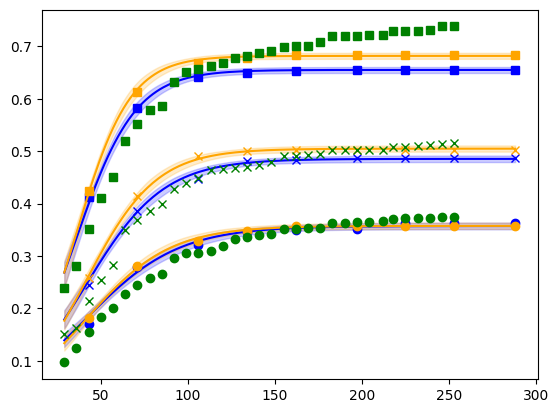

In [17]:
season_colors = {
    "2021-2022": "blue",
    "2022-2023": "orange",
    "2023-2024": "green",
}
strata_markers = {
    "18-49 years": "o",
    "50-64 years": "x",
    "65+ years": "s",
}

fig, ax = plt.subplots()

for season, color in season_colors.items():
    for stratum, marker in strata_markers.items():
        ax.fill_between(
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["time"],
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["prevalence_q005"],
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["prevalence_q995"],
            alpha=0.2,
            color=color,
        )
        ax.plot(
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["time"],
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["prevalence_q500"],
            color=color,
            label=f"{season} {stratum}",
        )
        ax.plot(
            incidence[
                (incidence["strata"] == stratum) & (incidence["season"] == season)
            ]["time"],
            incidence[
                (incidence["strata"] == stratum) & (incidence["season"] == season)
            ]["prevalence"],
            color=color,
            marker=marker,
            linestyle="None",
        )

plt.show()

-----

In [18]:
model_after = build_model(
    incidence[["time", "season", "region", "strata", "prevalence"]].rename(
        columns=lambda x: "value" if x == "prevalence" else x
    ),
    "prevalence",
    "rate",
    logistic_curve,
    pm.Gamma,
    (pm.HalfNormal, {"sigma": 0.1}),
    {
        "m": (pm.Normal, {"mu": 0.0, "sigma": 0.1}),
        "r": (pm.Normal, {"mu": -4.5, "sigma": 1.0}),
        "s": (pm.Normal, {"mu": 5.300e01, "sigma": 5.0}),
        "mStrata": (
            pm.Normal,
            {
                "mu": {"18-49 years": -0.6, "50-64 years": 0.0, "65+ years": 0.6},
                "sigma": 0.1,
            },
        ),
        "rStrata": (pm.Normal, {"mu": 0.0, "sigma": 0.25}),
        "sStrata": (pm.Normal, {"mu": 0.0, "sigma": 1.0}),
    },
    season_stratified_parameters=("m", "r", "s", "mStrata"),
    season_walk_sigma=0.15,
)
model_after

          mMacro ~ Normal(0, 0.1)
mStrata1849Years ~ RandomWalk(Normal(-0.6, 0.1), Normal(0, 0.15), f())
mStrata5064Years ~ RandomWalk(Normal(0, 0.1), Normal(0, 0.15), f())
  mStrata65Years ~ RandomWalk(Normal(0.6, 0.1), Normal(0, 0.15), f())
          rMacro ~ Normal(-4.5, 1)
         rStrata ~ Normal(0, 0.25)
          sMacro ~ Normal(53, 5)
         sStrata ~ Normal(0, 1)
         epsilon ~ HalfNormal(0, 0.1)
               m ~ Deterministic(f(mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro))
               r ~ Deterministic(f(rStrata, rMacro))
               s ~ Deterministic(f(sStrata, sMacro))
          yModel ~ Deterministic(f(mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro, sStrata, rStrata, sMacro, rMacro))
       yObserved ~ Gamma(f(epsilon, mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro, sStrata, rStrata, sMacro, rMacro), f(epsilon, mStrata65Years, mStrata5064Years, mStrata1849Years, mMacro, sStrata, rStrata, sMacro, rMacro))

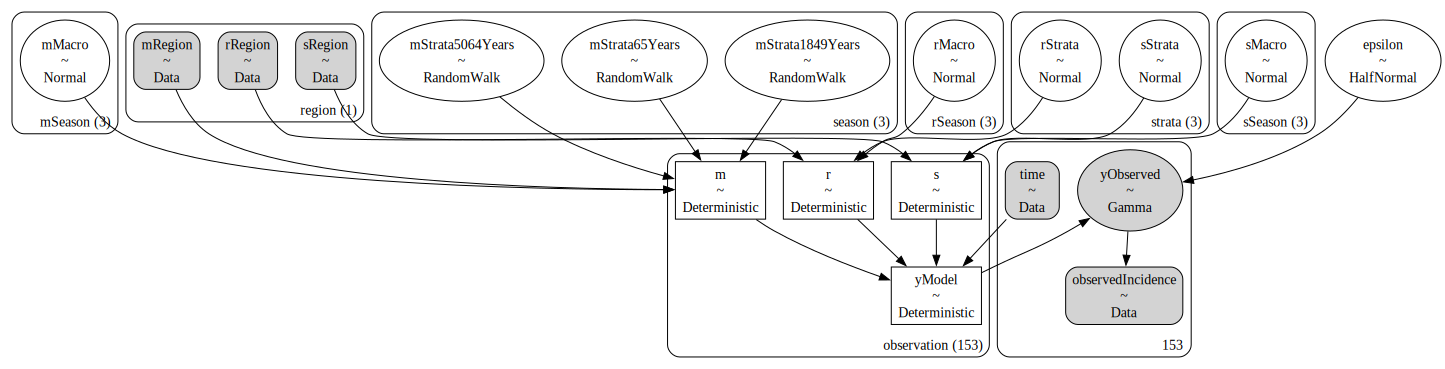

In [19]:
pm.model_to_graphviz(model_after)

In [20]:
with model_after:
    trace_after = pm.sample(
        draws=samples,
        tune=nchains * samples,
        chains=nchains,
        cores=nchains,
        random_seed=123,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 47 seconds.


In [21]:
az.summary(trace_after)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
mMacro[2021-2022]           -0.015  0.046  -0.102    0.071      0.001   
mMacro[2022-2023]            0.011  0.062  -0.106    0.129      0.001   
mMacro[2023-2024]            0.044  0.074  -0.104    0.176      0.002   
mStrata1849Years[2021-2022] -0.576  0.047  -0.658   -0.482      0.001   
mStrata1849Years[2022-2023] -0.601  0.063  -0.724   -0.485      0.001   
...                            ...    ...     ...      ...        ...   
yModel[148]                  0.716  0.002   0.711    0.720      0.000   
yModel[149]                  0.716  0.002   0.711    0.721      0.000   
yModel[150]                  0.716  0.002   0.711    0.721      0.000   
yModel[151]                  0.716  0.002   0.711    0.721      0.000   
yModel[152]                  0.716  0.002   0.712    0.721      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
mMacro[2021-2022]              0.001    2447.0    2806.0    1.0  
mMacro[2022-2023]              0.001    2057.0    2151.0    1.0  
mMacro[2023-2024]              0.001    1987.0    2141.0    1.0  
mStrata1849Years[2021-2022]    0.001    2579.0    2943.0    1.0  
mStrata1849Years[2022-2023]    0.001    2113.0    2253.0    1.0  
...                              ...       ...       ...    ...  
yModel[148]                    0.000    4089.0    3517.0    1.0  
yModel[149]                    0.000    4090.0    3485.0    1.0  
yModel[150]                    0.000    4092.0    3518.0    1.0  
yModel[151]                    0.000    4092.0    3491.0    1.0  
yModel[152]                    0.000    4094.0    3491.0    1.0  

[637 rows x 9 columns]

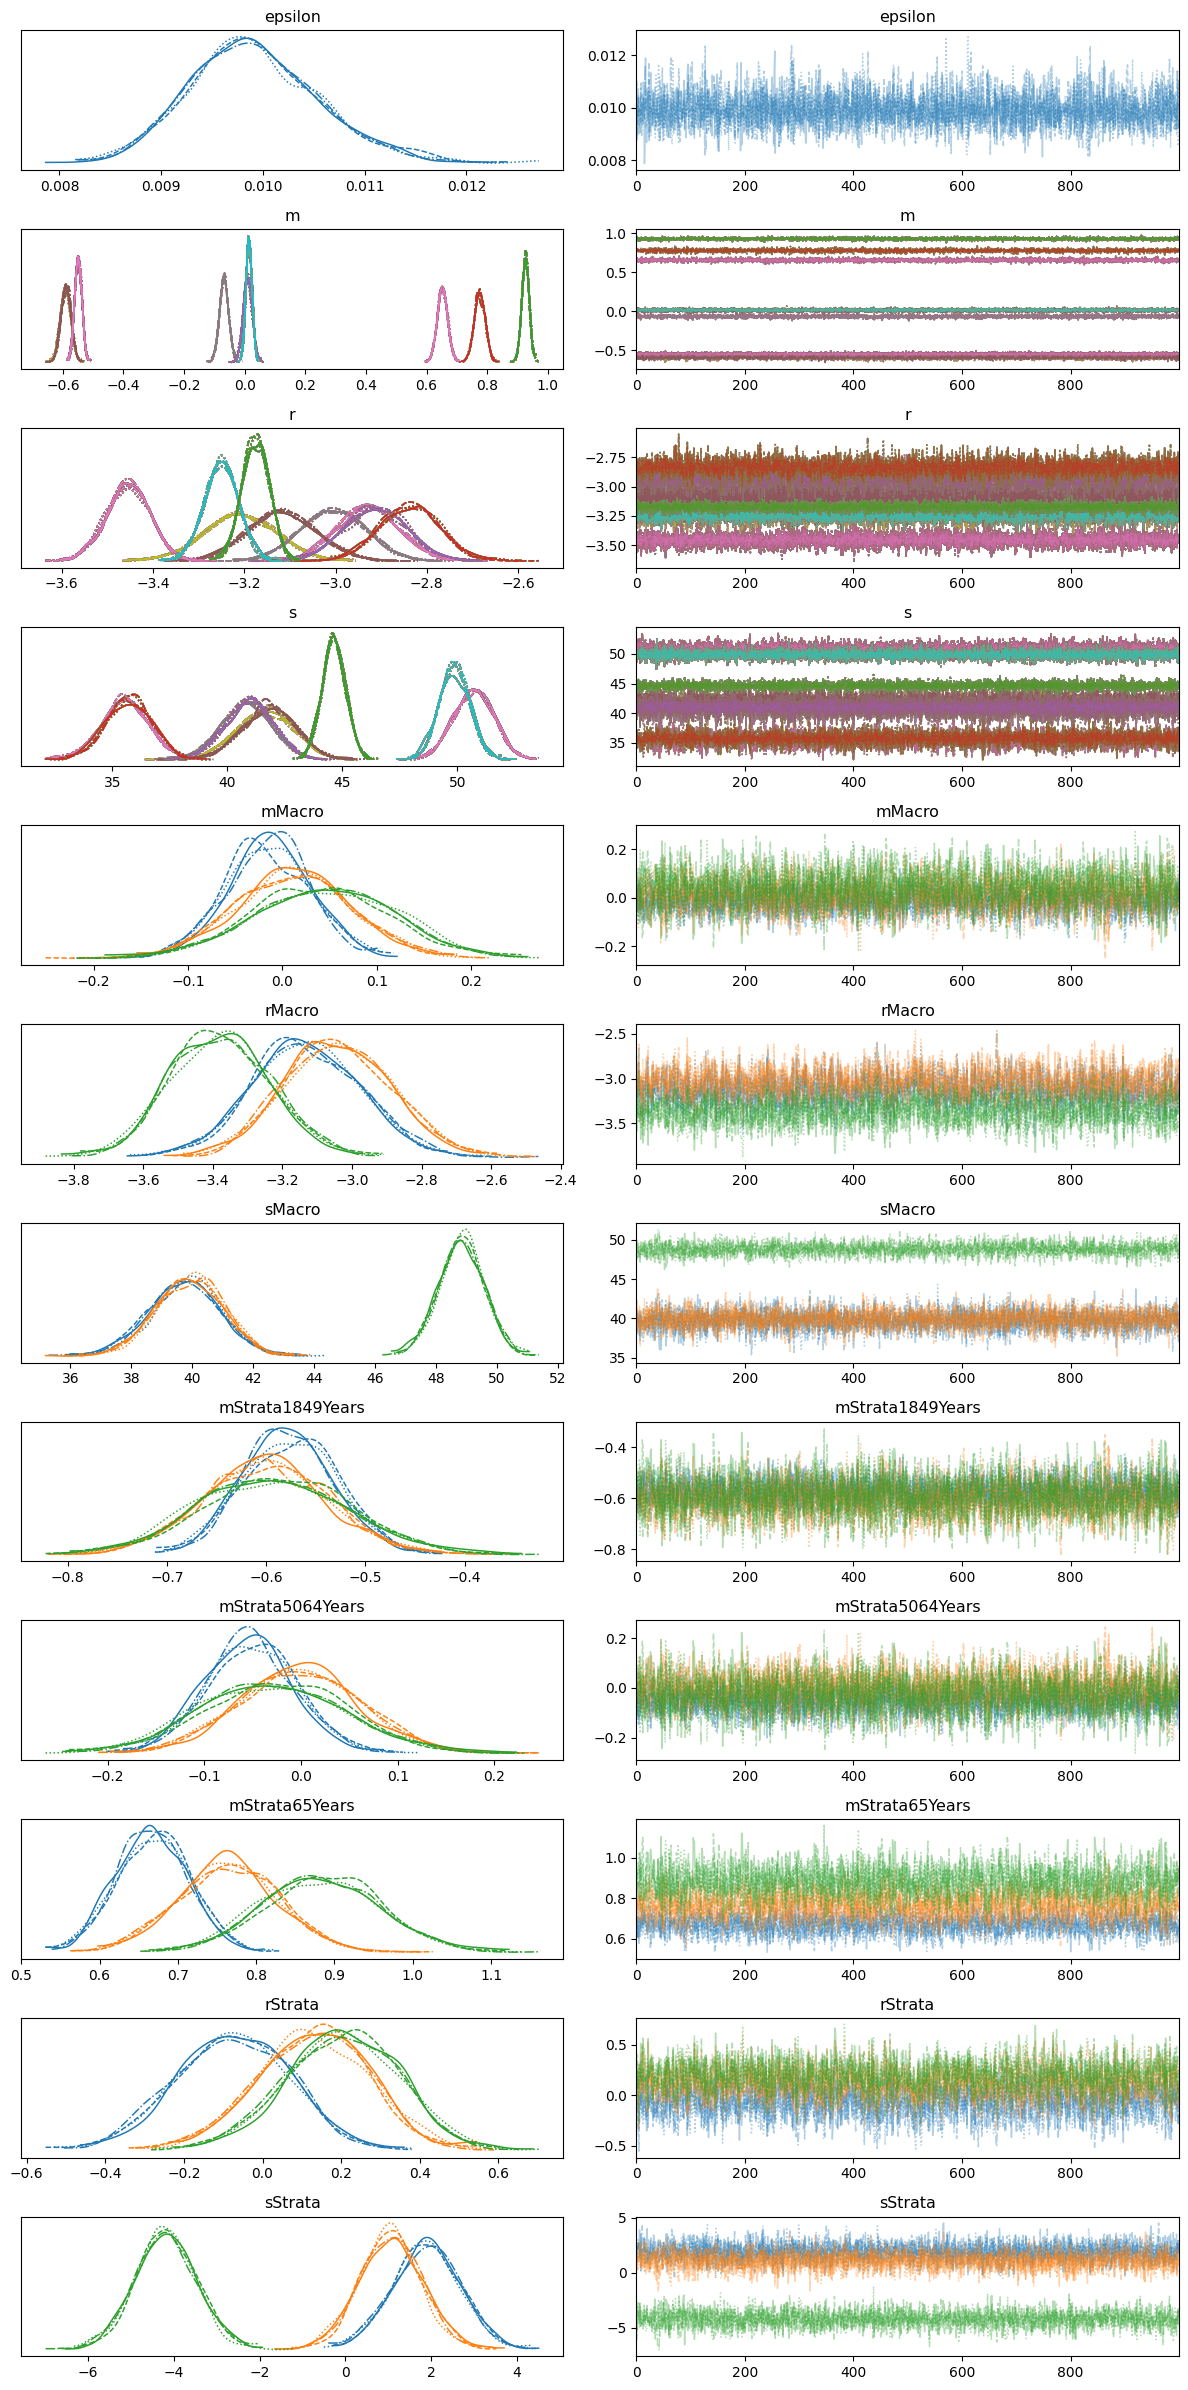

In [22]:
axes = az.plot_trace(
    trace_after,
    var_names=[
        "epsilon",
        "m",
        "r",
        "s",
        "mMacro",
        "rMacro",
        "sMacro",
        "mStrata1849Years",
        "mStrata5064Years",
        "mStrata65Years",
        "rStrata",
        "sStrata",
    ],
    kind="trace",
)
plt.tight_layout()

In [23]:
simulated = posterior_curve(
    np.arange(incidence["time"].min(), incidence["time"].max() + 1),
    trace_after,
    logistic_curve,
)
simulated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9360000 entries, 0 to 259
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   chain       int64  
 1   draw        int64  
 2   season      object 
 3   strata      object 
 4   time        int64  
 5   value       float64
 6   prevalence  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 571.3+ MB


In [24]:
trace_after.posterior.coords

Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * mSeason      (mSeason) <U9 108B '2021-2022' '2022-2023' '2023-2024'
  * season       (season) <U9 108B '2021-2022' '2022-2023' '2023-2024'
  * rSeason      (rSeason) <U9 108B '2021-2022' '2022-2023' '2023-2024'
  * strata       (strata) <U11 132B '18-49 years' '50-64 years' '65+ years'
  * sSeason      (sSeason) <U9 108B '2021-2022' '2022-2023' '2023-2024'
  * observation  (observation) <U3 2kB '0' '1' '2' '3' ... '150' '151' '152'

In [25]:
simulated_summary = (
    simulated.groupby(["season", "strata", "time"])[["value", "prevalence"]]
    .agg(
        [
            lambda x: np.quantile(x, 0.005),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, 0.995),
        ]
    )
    .reset_index()
)
simulated_summary.columns = simulated_summary.columns.to_flat_index()
simulated_summary = simulated_summary.rename(
    columns={
        k: v
        for k, v in zip(
            simulated_summary.columns,
            [
                "season",
                "strata",
                "time",
                "value_q005",
                "value_q500",
                "value_q995",
                "prevalence_q005",
                "prevalence_q500",
                "prevalence_q995",
            ],
        )
    }
)
simulated_summary

season       strata  time    value_q005  value_q500  value_q995  \
0     2021-2022  18-49 years    29  2.847926e-03    0.003370    0.003903   
1     2021-2022  18-49 years    30  2.865571e-03    0.003403    0.003963   
2     2021-2022  18-49 years    31  2.881645e-03    0.003434    0.004023   
3     2021-2022  18-49 years    32  2.894555e-03    0.003463    0.004074   
4     2021-2022  18-49 years    33  2.905933e-03    0.003489    0.004125   
...         ...          ...   ...           ...         ...         ...   
2335  2023-2024    65+ years   284  6.861404e-07    0.000001    0.000003   
2336  2023-2024    65+ years   285  6.559654e-07    0.000001    0.000002   
2337  2023-2024    65+ years   286  6.271173e-07    0.000001    0.000002   
2338  2023-2024    65+ years   287  5.995378e-07    0.000001    0.000002   
2339  2023-2024    65+ years   288  5.731712e-07    0.000001    0.000002   

      prevalence_q005  prevalence_q500  prevalence_q995  
0            0.115500         0.133685         0.150064  
1            0.119436         0.137056         0.152952  
2            0.123326         0.140491         0.155998  
3            0.127457         0.143945         0.159206  
4            0.131399         0.147403         0.162443  
...               ...              ...              ...  
2335         0.710053         0.716383         0.722832  
2336         0.710054         0.716385         0.722834  
2337         0.710055         0.716386         0.722836  
2338         0.710056         0.716387         0.722838  
2339         0.710056         0.716389         0.722839  

[2340 rows x 9 columns]

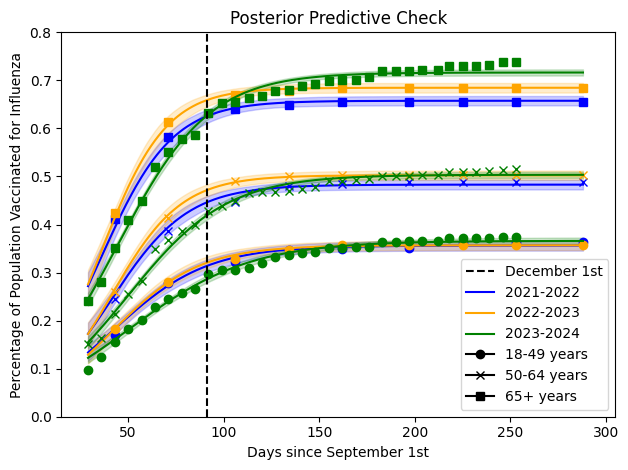

In [26]:
season_colors = {
    "2021-2022": "blue",
    "2022-2023": "orange",
    "2023-2024": "green",
}
strata_markers = {
    "18-49 years": "o",
    "50-64 years": "x",
    "65+ years": "s",
}

fig, ax = plt.subplots()

for season, color in season_colors.items():
    for stratum, marker in strata_markers.items():
        ax.fill_between(
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["time"],
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["prevalence_q005"],
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["prevalence_q995"],
            alpha=0.2,
            color=color,
        )
        ax.plot(
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["time"],
            simulated_summary[
                (simulated_summary["strata"] == stratum)
                & (simulated_summary["season"] == season)
            ]["prevalence_q500"],
            color=color,
            label=f"{season} {stratum}",
        )
        ax.plot(
            incidence[
                (incidence["strata"] == stratum) & (incidence["season"] == season)
            ]["time"],
            incidence[
                (incidence["strata"] == stratum) & (incidence["season"] == season)
            ]["prevalence"],
            color=color,
            marker=marker,
            linestyle="None",
        )

ax.set_xlabel("Days since September 1st")
ax.set_ylabel("Percentage of Population Vaccinated for Influenza")
ax.axvline(
    (pd.Timestamp("2023-12-01") - pd.Timestamp("2023-09-01")).days,
    color="black",
    linestyle="--",
)

ax.set_ylim((0.0, 0.8))
ax.set_xlim((15.0, 305.0))

custom_lines = (
    [Line2D([0], [0], color="black", linestyle="--")]
    + [Line2D([0], [0], color=v, linestyle="-") for v in season_colors.values()]
    + [Line2D([0], [0], color="black", marker=v) for v in strata_markers.values()]
)
custom_labels = ["December 1st", *season_colors.keys(), *strata_markers.keys()]
ax.legend(custom_lines, custom_labels, loc="lower right")

ax.set_title("Posterior Predictive Check")

plt.tight_layout()
plt.show()

-----

In [27]:
def create_plot(  # noqa: D103,PLR0915
    t: int, test_plot: bool = False, use_cache: bool = True, write_cache: bool = True
) -> None:
    # Subset the data
    incidence = globals()["incidence"].copy()
    incidence = incidence[
        incidence["time"] <= (date(2024, 3, 31) - date(2023, 9, 1)).days
    ]

    # Build model
    model_intermediate = build_model(
        incidence[
            (incidence["season"].isin(["2021-2022", "2022-2023"]))
            | ((incidence["season"] == "2023-2024") & (incidence["time"] <= t))
        ][["time", "season", "region", "strata", "prevalence"]].rename(
            columns=lambda x: "value" if x == "prevalence" else x
        ),
        "prevalence",
        "rate",
        logistic_curve,
        pm.Normal,
        (pm.HalfNormal, {"sigma": 0.1}),
        {
            "m": (pm.Normal, {"mu": 0.0, "sigma": 0.1}),
            "r": (pm.Normal, {"mu": -4.5, "sigma": 1.0}),
            "s": (pm.Normal, {"mu": 5.300e01, "sigma": 5.0}),
            "mStrata": (
                pm.Normal,
                {
                    "mu": {"18-49 years": -0.6, "50-64 years": 0.0, "65+ years": 0.6},
                    "sigma": 0.1,
                },
            ),
            "rStrata": (pm.Normal, {"mu": 0.0, "sigma": 0.25}),
            "sStrata": (pm.Normal, {"mu": 0.0, "sigma": 1.0}),
        },
        season_stratified_parameters=("m", "r", "s", "mStrata"),
        season_walk_sigma=0.15,
    )

    # Sample the model
    if use_cache and os.path.exists(f"model_intermediate_{t}.nc"):
        trace_intermediate = az.from_netcdf(f"model_intermediate_{t}.nc")
    else:
        with model_intermediate:
            trace_intermediate = pm.sample(
                draws=samples // (4 if test_plot else 1),
                tune=(nchains * samples) // (4 if test_plot else 1),
                chains=nchains,
                cores=nchains,
                random_seed=123,
            )
        if write_cache:
            trace_intermediate.to_netcdf(f"model_intermediate_{t}.nc")

    # Get simulated curves
    simulated = posterior_curve(
        np.arange(incidence["time"].min(), incidence["time"].max() + 1),
        trace_intermediate,
        logistic_curve,
    )

    # Get a summary of the simulated curves
    simulated_summary = (
        simulated.groupby(["season", "strata", "time"])[["value", "prevalence"]]
        .agg(
            [
                lambda x: np.quantile(x, 0.005),
                lambda x: np.quantile(x, 0.5),
                lambda x: np.quantile(x, 0.995),
            ]
        )
        .reset_index()
    )
    simulated_summary.columns = simulated_summary.columns.to_flat_index()
    simulated_summary = simulated_summary.rename(
        columns={
            k: v
            for k, v in zip(
                simulated_summary.columns,
                [
                    "season",
                    "strata",
                    "time",
                    "value_q005",
                    "value_q500",
                    "value_q995",
                    "prevalence_q005",
                    "prevalence_q500",
                    "prevalence_q995",
                ],
            )
        }
    )

    # Make a plot
    season_colors = {
        "2021-2022": "grey",
        "2022-2023": "grey",
        "2023-2024": "orange",
    }

    strata_markers = {
        "18-49 years": "o",
        "50-64 years": "X",
        "65+ years": "s",
    }

    historical_seasons = ("2021-2022", "2022-2023")

    fig, ax = plt.subplots()

    for season, color in season_colors.items():
        for stratum, marker in strata_markers.items():
            if season == "2023-2024":
                ax.fill_between(
                    simulated_summary[
                        (simulated_summary["strata"] == stratum)
                        & (simulated_summary["season"] == season)
                    ]["time"],
                    simulated_summary[
                        (simulated_summary["strata"] == stratum)
                        & (simulated_summary["season"] == season)
                    ]["prevalence_q005"],
                    simulated_summary[
                        (simulated_summary["strata"] == stratum)
                        & (simulated_summary["season"] == season)
                    ]["prevalence_q995"],
                    alpha=0.3,
                    color=color,
                )
            ax.plot(
                simulated_summary[
                    (simulated_summary["strata"] == stratum)
                    & (simulated_summary["season"] == season)
                ]["time"],
                simulated_summary[
                    (simulated_summary["strata"] == stratum)
                    & (simulated_summary["season"] == season)
                ]["prevalence_q500"],
                color=color,
                linewidth=1.5,
                alpha=0.5 if season in historical_seasons else 1.0,
            )
            if season == "2023-2024":
                ax.plot(
                    incidence[
                        (incidence["time"] <= t)
                        & (incidence["strata"] == stratum)
                        & (incidence["season"] == season)
                    ]["time"],
                    incidence[
                        (incidence["time"] <= t)
                        & (incidence["strata"] == stratum)
                        & (incidence["season"] == season)
                    ]["prevalence"],
                    color=color,
                    marker=marker,
                    linestyle="None",
                )
                ax.plot(
                    incidence[
                        (incidence["time"] > t)
                        & (incidence["strata"] == stratum)
                        & (incidence["season"] == season)
                    ]["time"],
                    incidence[
                        (incidence["time"] > t)
                        & (incidence["strata"] == stratum)
                        & (incidence["season"] == season)
                    ]["prevalence"],
                    color=color,
                    marker=marker,
                    markerfacecolor="none",
                    linestyle="None",
                )
            else:
                ax.plot(
                    incidence[
                        (incidence["strata"] == stratum)
                        & (incidence["season"] == season)
                    ]["time"],
                    incidence[
                        (incidence["strata"] == stratum)
                        & (incidence["season"] == season)
                    ]["prevalence"],
                    color=color,
                    marker=marker,
                    linestyle="None",
                    alpha=0.5,
                )

    ax.set_xlabel("Days since September 1st")
    ax.set_ylabel("Percentage of Population Vaccinated")
    # ax.axvline(
    #     (pd.Timestamp("2023-12-01") - pd.Timestamp("2023-09-01")).days,
    #     color="black",
    #     linestyle="--",
    # )

    ax.axvline(t, color="orange", linestyle="-")
    # x_off = 2.0
    y_off = 0.09
    ax.text(
        t + 2.0,
        y_off,
        (date(2023, 9, 1) + timedelta(days=t)).strftime("%b %d"),
        rotation=90,
        # verticalalignment="top",
        # horizontalalignment="center",
        verticalalignment="center",
        horizontalalignment="left",
    )
    ax.text(
        t - 1.0,
        y_off,
        "As Of",
        rotation=90,
        verticalalignment="center",
        horizontalalignment="right",
    )

    ax.set_ylim((0.0, 0.8))
    # ax.set_xlim((15.0, 305.0))
    ax.set_xlim((incidence["time"].min() - 8.0, incidence["time"].max() + 8.0))

    for y in np.arange(0.2, 0.8, 0.2):
        ax.axhline(y, color="black", linestyle="--", alpha=0.5)

    custom_lines = (
        []
        # [Line2D([0], [0], color="black", linestyle="--")]
        # + [Line2D([0], [0], color=v, linestyle="-") for v in season_colors.values()]
        + [
            Line2D([0], [0], color="grey", linestyle="-"),
            Line2D([0], [0], color="orange", linestyle="-"),
        ]
        + [Line2D([0], [0], color="black", marker=v) for v in strata_markers.values()]
    )
    custom_labels = ["Historical", "Current", *strata_markers.keys()]
    ax.legend(custom_lines, custom_labels, loc="upper left")

    # dt = (date(2023, 9, 1) + timedelta(days=t)).strftime("%B %d, %Y")
    ax.set_title("Fitted Uptake For The 2023/24 Season")

    start_date = date(2023, 8, 1)
    color = False
    while start_date <= date(2024, 4, 1):
        x_left = (start_date - date(2023, 9, 1)).days
        x_right = (
            (start_date.replace(month=start_date.month + 1) - date(2023, 9, 1)).days
            if start_date.month != 12
            else (
                start_date.replace(year=start_date.year + 1, month=1) - date(2023, 9, 1)
            ).days
        )
        if date(2023, 10, 1) <= start_date <= date(2024, 3, 1):
            ax.text(
                (x_left + x_right) / 2,
                0.02,
                start_date.strftime("%b"),
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=8,
            )
        if color:
            ax.axvspan(x_left, x_right, color="grey", alpha=0.1)
        # ax.axvline(
        #     (start_date - date(2023, 9, 1)).days,
        #     color="black",
        #     linestyle="--",
        #     alpha=0.5,
        # )
        start_date = (
            start_date.replace(year=start_date.year + 1, month=1)
            if start_date.month == 12
            else start_date.replace(month=start_date.month + 1)
        )
        color = not color

    fig.tight_layout()
    fig.savefig(f"uptake_{t}.png")

In [28]:
times_list = sorted(
    incidence[incidence["season"] == "2023-2024"]["time"].unique().tolist()
)
", ".join([str(t) for t in times_list])

'29, 36, 43, 50, 57, 64, 71, 78, 85, 92, 99, 106, 113, 120, 127, 134, 141, 148, 155, 162, 169, 176, 183, 190, 197, 204, 212, 218, 225, 232, 239, 246, 253'

In [29]:
# # Test plot
# create_plot(times_list[2], test_plot=True, use_cache=False, write_cache=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 19 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 21 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 23 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 21 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 22 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 23 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 23 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 24 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 24 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 27 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 29 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 30 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 33 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 33 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 34 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 36 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 36 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 37 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 38 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 39 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 38 seconds.
/var/folders/2z/h3pc0p7s3ng1tvxrgsw5kr680000gp/T/ipykernel_67084/1428645060.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 37 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 37 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 38 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mMacro, mStrata1849Years, mStrata5064Years, mStrata65Years, rMacro, rStrata, sMacro, sStrata, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 38 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


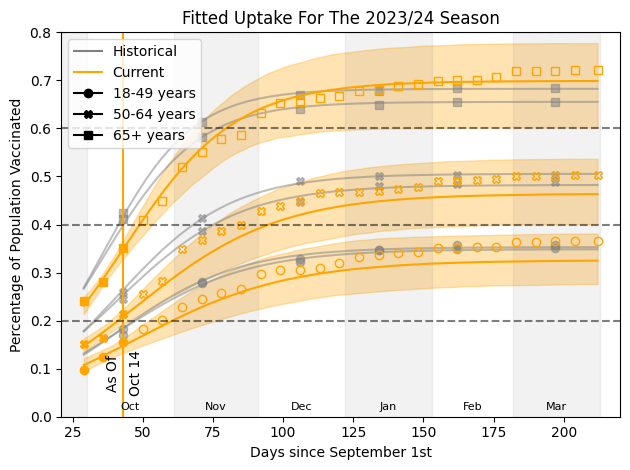

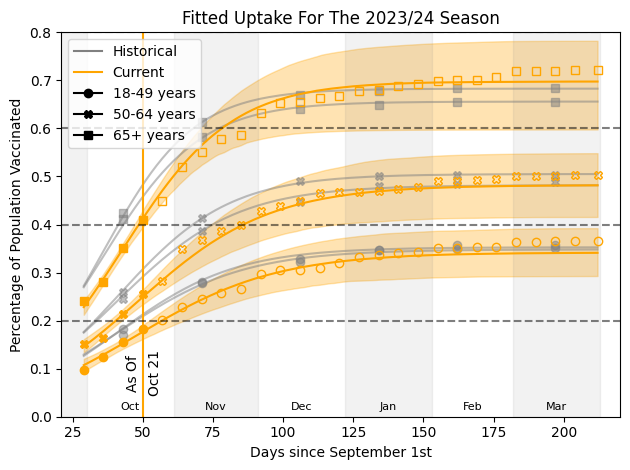

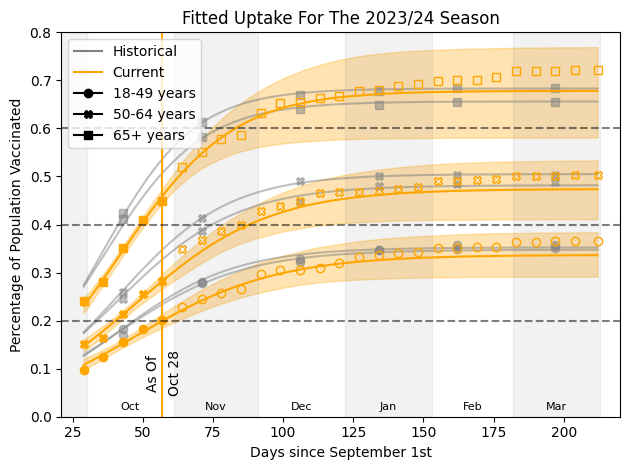

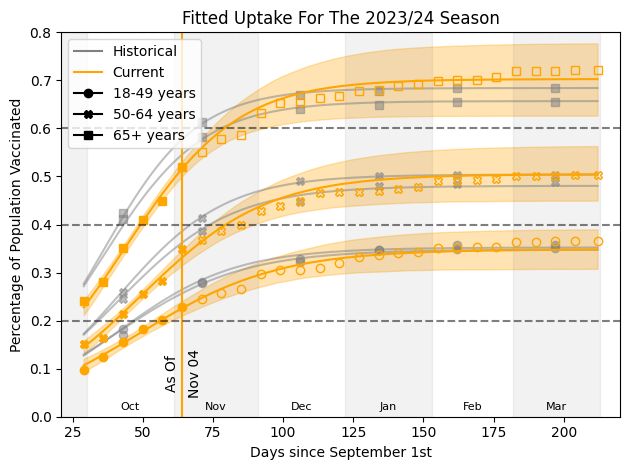

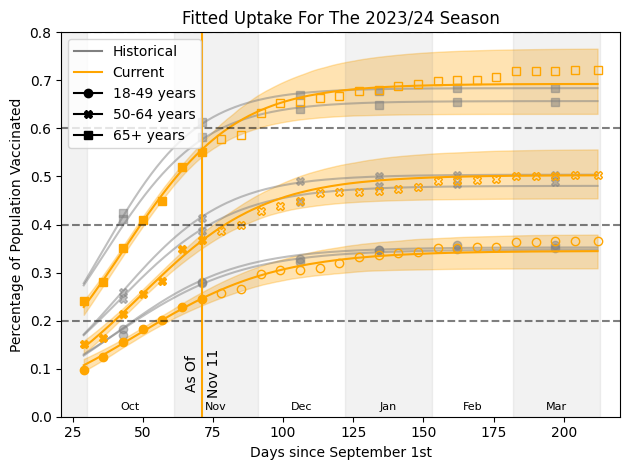

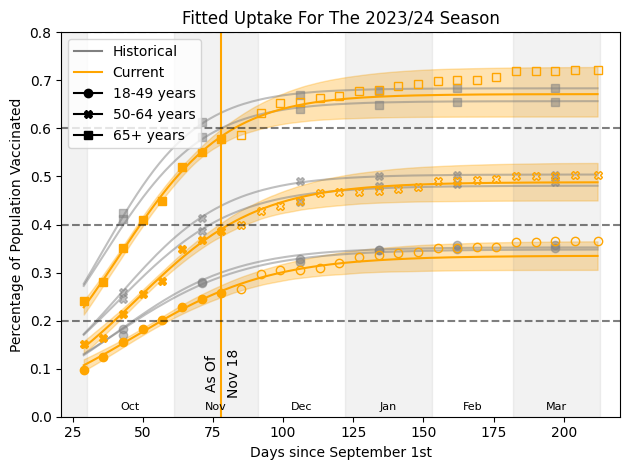

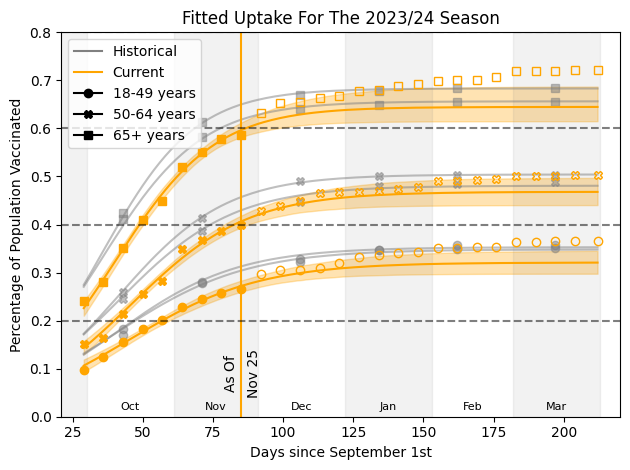

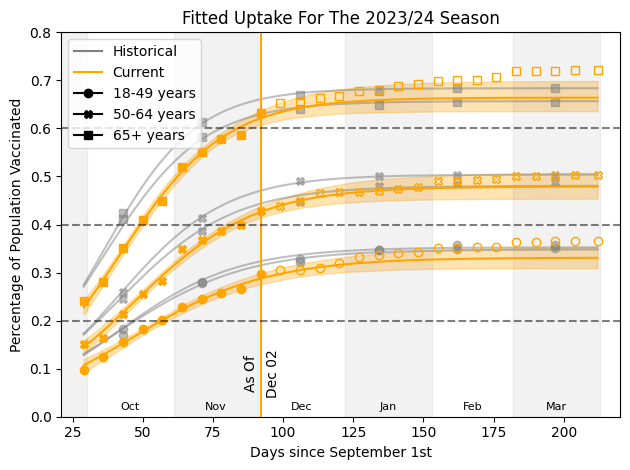

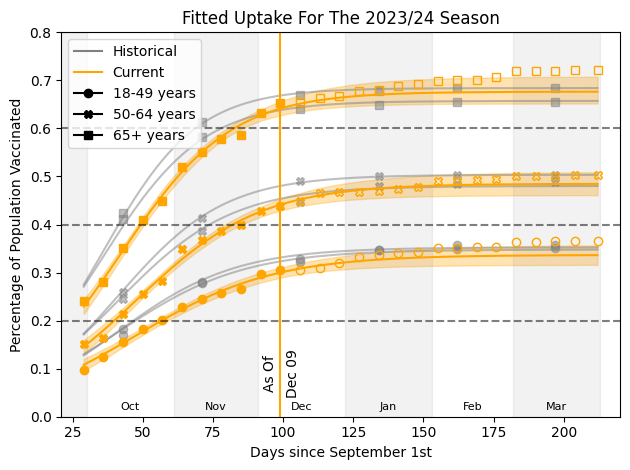

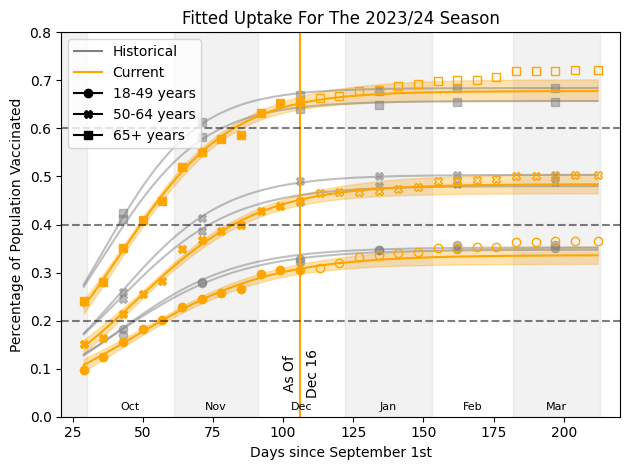

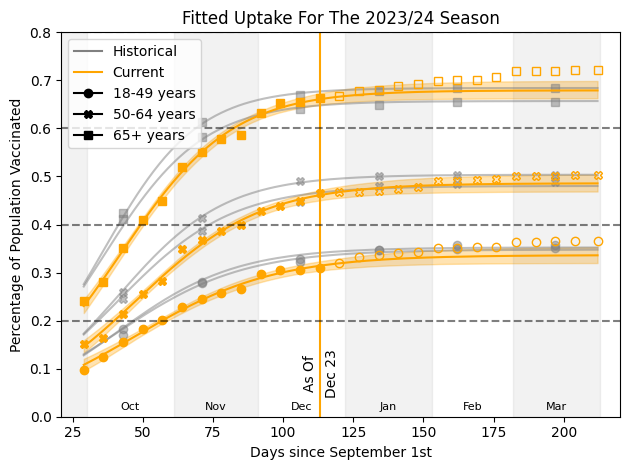

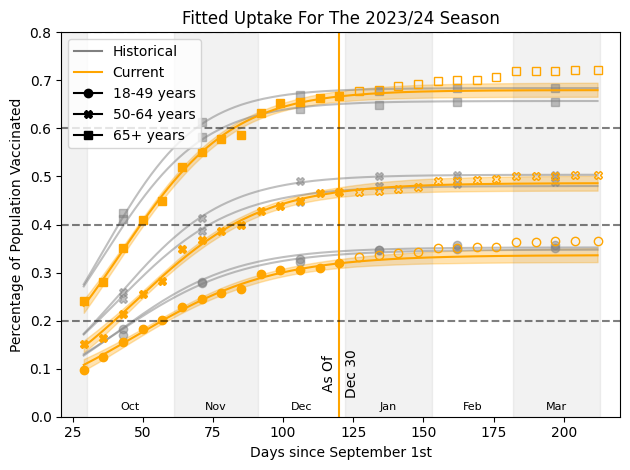

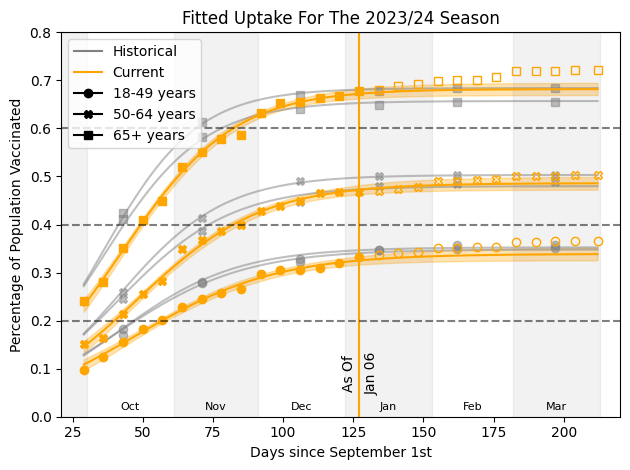

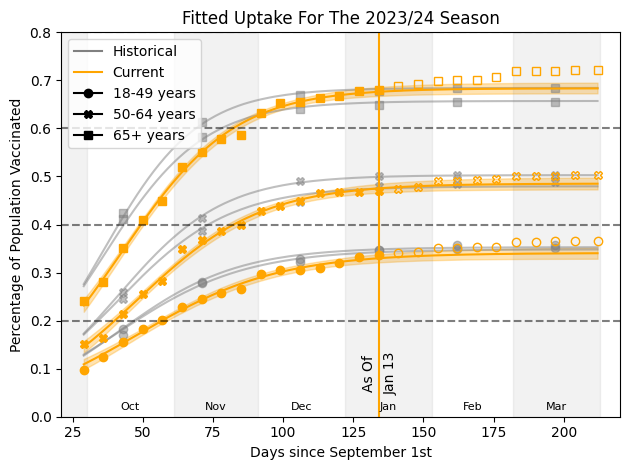

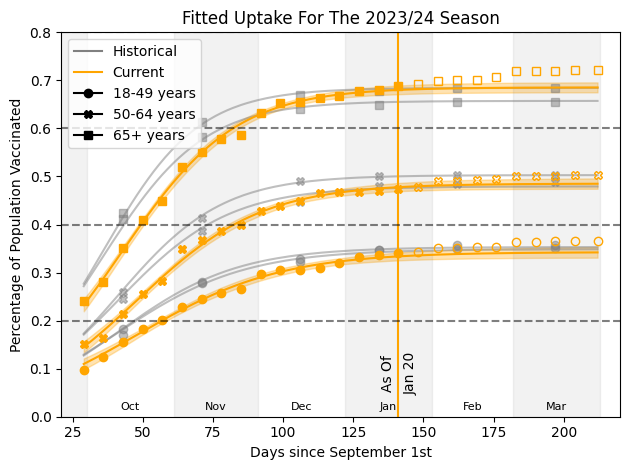

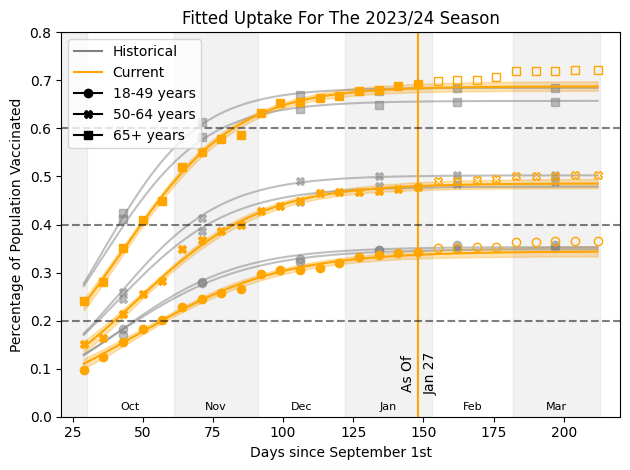

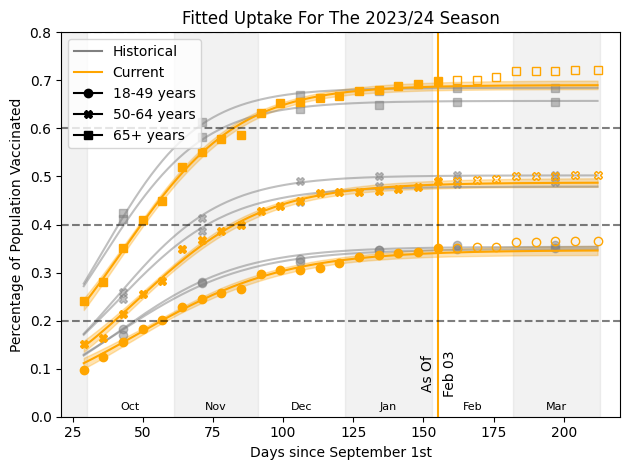

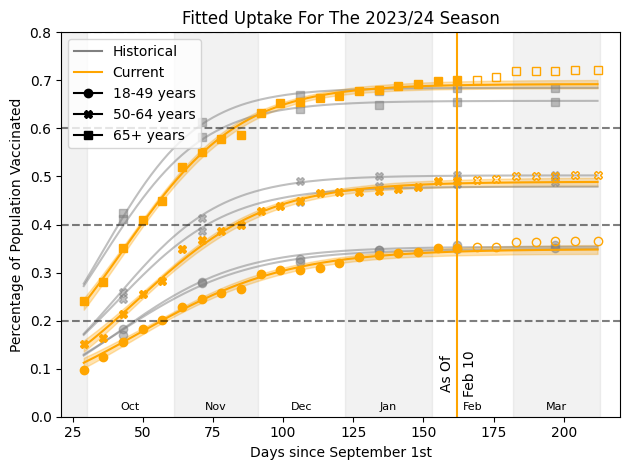

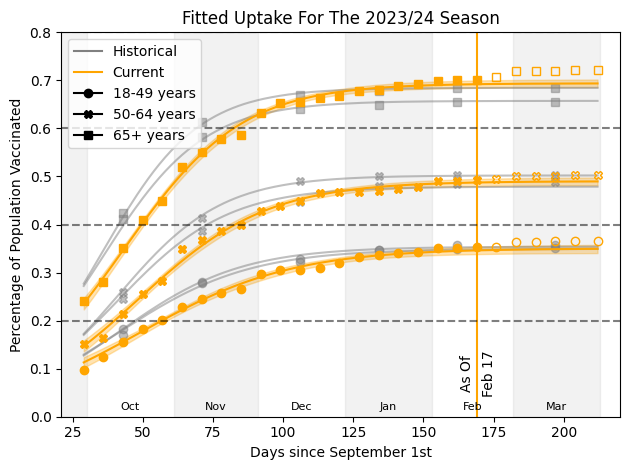

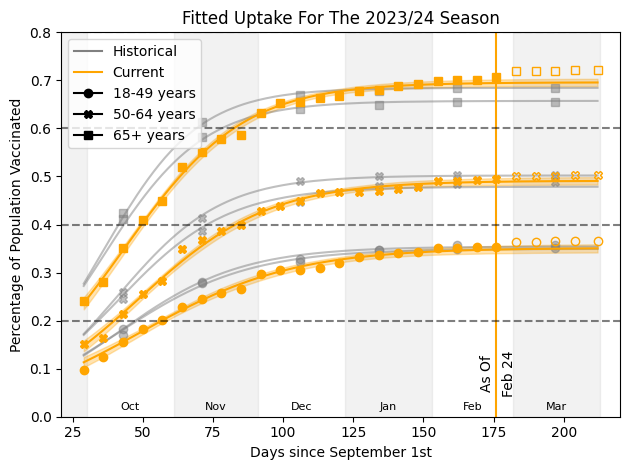

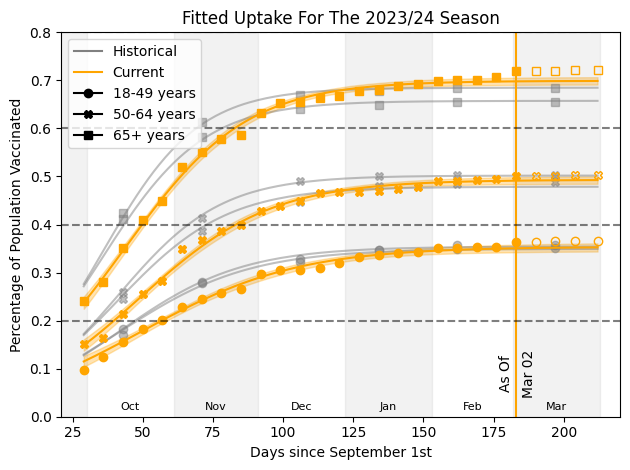

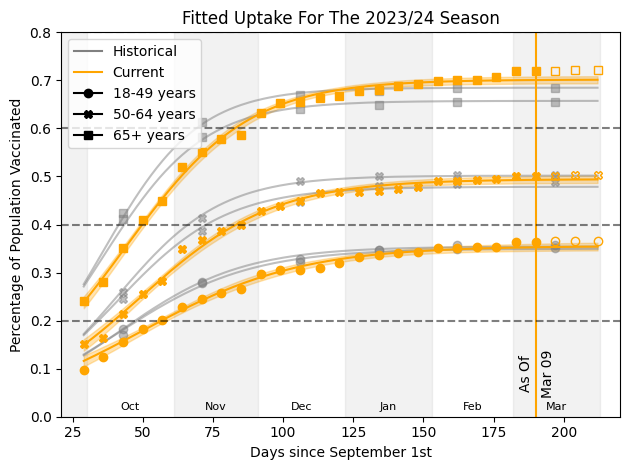

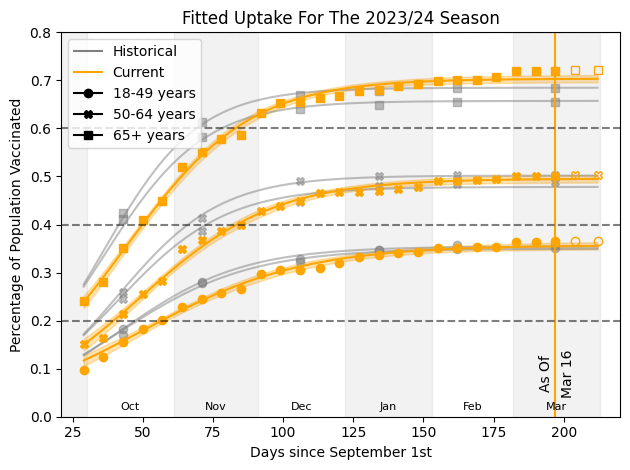

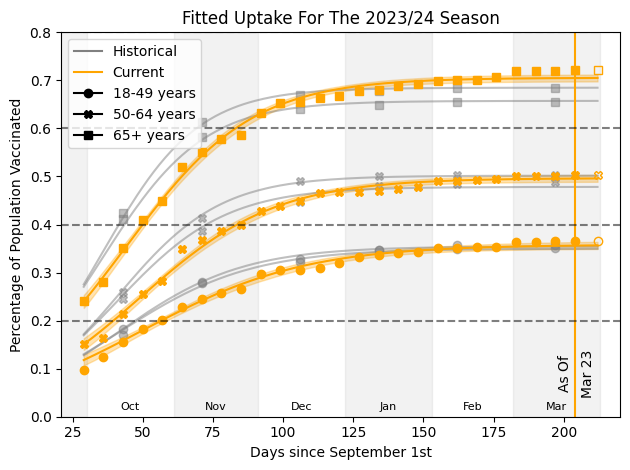

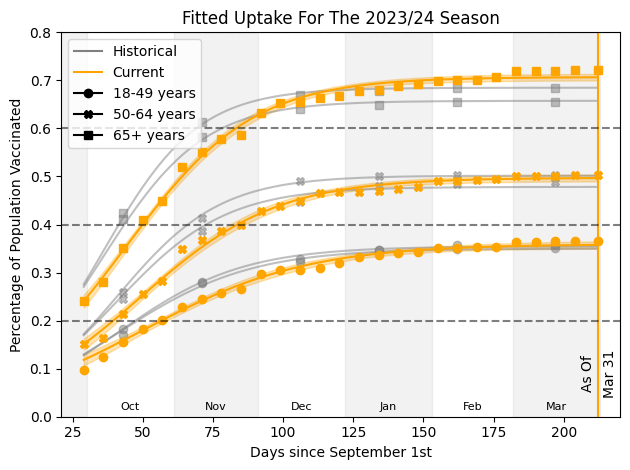

In [30]:
for i in range(2, len(times_list)):
    if times_list[i] <= (date(2024, 3, 31) - date(2023, 9, 1)).days:
        create_plot(times_list[i])